# NLP Assignment 1 (40% of grade): Sentiment Analysis from Tweets

This coursework will involve you implementing functions for a text classifier, which you will train to identify the **sentiment expressed in a text** in a dataset of approx. 27,000 entries, which will be split into a 80%/20% training/test split.

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [22]:
!pip install emoji

In [23]:
import csv                               # csv reader
import re
import json
import emoji
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from nltk.corpus import stopwords, wordnet, sentiwordnet
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag
import nltk
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
from math import log
import numpy as np

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [24]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [25]:
def parse_data_line(data_line):
    # Should return a tuple of the label as just positive or negative and the statement
    # e.g. (label, statement)

    return (data_line[1], data_line[2])

In [26]:
# Input: a string of one statement
# Load a dictionary of common contractions
with open("contractions.json", "r") as file:
   contractions = json.load(file)
def pre_process(text, normalise_contractions = False, remove_stopwords = False,
                remove_links = False, remove_handles = False, remove_punctuation = False,
                allcaps_count = False, model = 'svc'):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS

    # normalisation of common contractions
    if normalise_contractions:
      for key in contractions:
        contractions[key] = contractions[key].replace(" / ", "")
        key_no_apstr = re.sub(r"'", "", key)
        text = re.sub(r"\b" + key + r"\b", contractions[key], text)
        text = re.sub(r"\b" + key_no_apstr + r"\b", contractions[key], text)

    # word tokenisation
    if remove_links:
      text = re.sub(r"https?://\S+|www\.\S+", "", text) # removes links
    if remove_handles:
      text = re.sub(r"@\S+\S*", "", text) # removes handles
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings

    # demarcate emojis
    emojis = [match['emoji'] for match in emoji.emoji_list(text)]
    for em in emojis: # add spaces around each emoji in the text
      text = text.replace(em, f' {em} ')

    print("tokenising:", text)
    tokens = re.split(r"\s+",text)

    # preparing to count the number of all-caps tokens in the to_feature_vector function
    if allcaps_count:
      tokens = tokens + ['ALLCAPS' for t in tokens if t.isupper()]

    # normalisation by lower-casing
    tokens = [t if t == 'ALLCAPS' else t.lower() for t in tokens]

    # lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # stopword removal
    if remove_stopwords:
      stop_words = set(stopwords.words('english'))
      tokens = [t for t in tokens if t not in stop_words or not t.isalnum()]

    # removal of seemingly unimportant punctuation:
    if remove_punctuation:
      tokens = [t for t in tokens if t not in '”#$%&’()*+,-./:;<=>?[\]^_`{|}~']

    global nb, st
    nb, st = False, False

    if model == 'nb':
      nb = True

    if model == 'stack':
      st = True

    return tokens

# Question 2: Basic Feature Extraction (20 marks)

In [27]:
global_feature_dict = {} # A global dictionary of features

# Convert pos tag to format used by wordnet lemmatizer
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
# Get positivity and negativity scores from sentiwordnet for a given word and its POS tag
def get_sentiwordnet_scores(word, pos_tag):
    wn_pos = get_wordnet_pos(pos_tag)
    if wn_pos is None:
        return 0, 0

    # lemmatize the word and look it up in sentiwordnet
    lemmatizer = WordNetLemmatizer()
    lemma = lemmatizer.lemmatize(word, pos=wn_pos)
    synsets = list(sentiwordnet.senti_synsets(lemma, wn_pos))
    if not synsets:
        return 0, 0

    # average the scores across all synsets for the word
    pos_score = sum(synset.pos_score() for synset in synsets) / len(synsets)
    neg_score = sum(synset.neg_score() for synset in synsets) / len(synsets)
    return pos_score, neg_score

def to_feature_vector(tokens, n_grams = 2):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    # initialise feature vector
    fv = {}
    # make sure global dictionary is updated globally
    global global_feature_dict

    # extract unigrams, bigrams, and trigrams
    unigrams = tokens
    bigrams = list(ngrams(tokens, 2))
    trigrams = list(ngrams(tokens, 3))
    ngram_list = [unigrams, bigrams, trigrams]

    # combine all n-grams into a single list
    all_ngrams = []
    for i in range(n_grams):
      all_ngrams += ngram_list[i]

    # count the occurrences of each n-gram in the feature vector and global dictionary
    for ngram in all_ngrams:
        # convert n-grams into a string representation (for bigrams/trigrams)
        ngram_str = " ".join(ngram) if isinstance(ngram, tuple) else ngram

        # update the global feature dictionary and feature vector
        if ngram_str in global_feature_dict:
            global_feature_dict[ngram_str] += 1
            fv[ngram_str] = fv.get(ngram_str, 0) + 1
        else:
            global_feature_dict[ngram_str] = 1
            fv[ngram_str] = 1

    # calculate positivity and negativity scores using sentiwordnet
    pos_total, neg_total = 0, 0
    tagged_tokens = pos_tag(unigrams)
    for word, tag in tagged_tokens:
        pos_score, neg_score = get_sentiwordnet_scores(word, tag)
        pos_total += pos_score
        neg_total += neg_score

    # add the average sentiment scores as features and add the new features to the
    # global dictionary

    fv['positivity_score'] = pos_total/len(unigrams) if len(unigrams) > 0 else 0
    fv['negativity_score'] = neg_total/len(unigrams) if len(unigrams) > 0 else 0
    global_feature_dict['positivity_score'] = 'Special'
    global_feature_dict['negativity_score'] = 'Special'

    return fv

# Changing the weights of the tokens to TF-IDF
def tfidf(data, trim = False):
  # calculate document frequencies (DF) for each token
  df = {}
  special = ['positivity_score', 'negativity_score']
  for text, _ in data:
      for token in text:
        if token not in special:
          df[token] = df.get(token, 0) + 1

  # calculate TF-IDF with smoothing and L2 normalization
  tfidf_data = []
  for text, label in data:
      text_tfidf = {}
      for token, count in text.items():
        if token not in special:
          # Term Frequency (TF)
          tf = count/sum(text.values())
          # smoothed Inverse Document Frequency (IDF)
          idf = log((len(data)+1)/(df[token]+1)) + 1
          # TF-IDF
          text_tfidf[token] = tf*idf
        else:
          text_tfidf[token] = count

      # apply L2 normalization
      norm = np.sqrt(sum(value**2 for value in text_tfidf.values()))
      if norm > 0:
          text_tfidf = {token: value/norm for token, value in text_tfidf.items()}

      # remove likely uninformative features
      if trim:
        for token in text:
          if text_tfidf[token] < 0.05:
            del text_tfidf[token]

      tfidf_data.append((text_tfidf, label))

  return tfidf_data

In [28]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    if not nb and not st:
      pipeline =  Pipeline([('svc', LinearSVC(class_weight='balanced'))])
    elif nb:
      pipeline = Pipeline([('nb', MultinomialNB())])
    else:
      nb_model = MultinomialNB()
      svc_model = LinearSVC(class_weight='balanced')
      st_model = StackingClassifier(estimators=[('nb', nb_model), ('svc', svc_model)],
                                    final_estimator=LogisticRegression(),
                                    cv = 3)
      pipeline = Pipeline([('st', st_model)])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [29]:
#solution
from sklearn.metrics import classification_report


def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1

    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        # FILL IN THE METHOD HERE
        print("Fold start on items %d - %d" % (i, i+fold_size))

        # split the dataset into temporary train and test data
        train = dataset[:i] + dataset[i+fold_size:]
        train = tfidf(train)
        test = dataset[i:i+fold_size]
        test = tfidf(test)

        # record the true and predicted test labels
        classifier = train_classifier(train)
        test_true = [t[1] for t in test]
        test_pred = predict_labels([x[0] for x in test], classifier)

        # calculate the average of the metrics over all the labels weighted
        # by each label's support (true instance count)
        prelim = list(precision_recall_fscore_support(test_true, test_pred,
                                                       average='weighted'))[:3]
        accuracy = sum([1 for i in range(len(test_true)) if test_true[i] == test_pred[i]]) / len(test_true)
        results.append(prelim + [accuracy])

    # return the four basic metrics using a weighted average
    return [np.mean([r[i] for r in results]) for i in range(4)]

In [30]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [31]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')

Streaming output truncated to the last 5000 lines.
tokenising: Saw the PlayStation 20th Anniversary PS4 controller up close today . Oh , man , do I want this ( as a huge fan of the original PlayStation ).
tokenising: Fantastic Four tomorrow will it be as good as Ant-Man we ' ll have to see
tokenising: I wish I was out MD I wanna bear on Negros shit is fun , going out Sunday to Ross snighter Sunday Finna pop off on TWL
tokenising: you know you ' re officially into kpop when you spend your Saturday watching the  @PathcodeEXO documentaries in between homework LOL
tokenising: David Wright is back and had a big impact in the win tonight . Mets are now 12 games over . 500 , 5 . 5 games ahead in 1st , I can see October !
tokenising: At 12 : 00 AM - Hey Yakub , Happy birthday ... May God give you a long life   *awkward silence*
tokenising: Hey @SDuPreeBemis :) Support to the Philippines ? Cybercrime Law to be in full effect tomorrow . Our version of SOPA #JunktheCybercrimeLaw
tokenising: I thi

In [32]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 2684
Training Classifier...
Fold start on items 2684 - 5368
Training Classifier...
Fold start on items 5368 - 8052
Training Classifier...
Fold start on items 8052 - 10736
Training Classifier...
Fold start on items 10736 - 13420
Training Classifier...
Fold start on items 13420 - 16104
Training Classifier...
Fold start on items 16104 - 18788
Training Classifier...
Fold start on items 18788 - 21472
Training Classifier...
Fold start on items 21472 - 24156
Training Classifier...
Fold start on items 24156 - 26840
Training Classifier...


[0.8748689187498174,
 0.8754106714427967,
 0.8749186133980544,
 0.8754106714427967]

# Question 4: Error Analysis (20 marks)

In [33]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

Training Classifier...


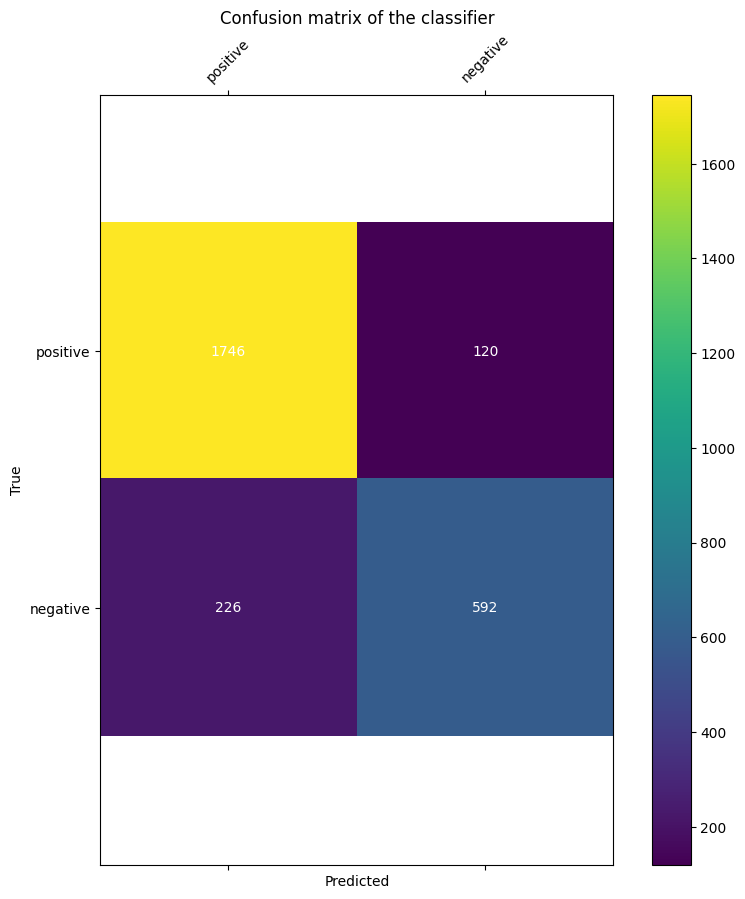

In [34]:
train = train_data[int(len(train_data)/10) + 1:]
test = train_data[:int(len(train_data)/10) + 1]
# record the true and predicted test labels
classifier = train_classifier(train)
test_true = [t[1] for t in test]
test_pred = predict_labels([x[0] for x in test], classifier)
confusion_matrix_heatmap(test_true, test_pred, ['positive', 'negative'])

In [35]:
with open('mislabelled_tweets.txt', 'w') as f:
  print('False negatives: \n', file=f)
  for i in range(len(test_true)):
      if test_true[i] != test_pred[i] and test_true[i] == 'positive':
        print(f'Original text: {raw_data[i][0]}', file=f)
        print(f'Feature dictionary: {test[i][0]}', file=f)
  print('\nFalse positives: \n', file=f)
  for i in range(len(test_true)):
      if test_true[i] != test_pred[i] and test_true[i] == 'negative':
        print(f'Original text: {raw_data[i][0]}', file=f)
        print(f'Feature dictionary: {test[i][0]}', file=f)

# Questions 5: Optimising pre-processing and feature extraction (30 marks)

**Note:** it is advisable to implement question 5 in a separate notebook where you further develop the pre-processing and feature extraction functions you implemented above.

In [36]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    train_d = tfidf(train_data)
    test_d = tfidf(test_data)
    print(test_d[0])   # have a look at the first test data instance
    classifier = train_classifier(train_d)  # train the classifier
    test_t = [t[1] for t in test_d]   # get the ground-truth labels from the data
    test_p = predict_labels([x[0] for x in test_d], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_t, test_p, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])
    print(f'Accuracy: {sum([1 for i in range(len(test_t)) if test_t[i] == test_p[i]]) / len(test_t)}')

({'tomorrow': 0.05743439907481363, 'we': 0.14524515257968149, "'": 0.07559318197794154, 'll': 0.17571706944425616, 'release': 0.12503362447807173, 'our': 0.18814916834401693, '58th': 0.17692114794824873, 'episode': 0.11125253627280897, 'of': 0.04973886989246524, '#hsonair': 0.17692114794824873, 'profiling': 0.17692114794824873, 'very': 0.10305902763442186, 'own': 0.12312355429943787, '@alissadossantos': 0.17692114794824873, '!': 0.1026415233449589, 'talk': 0.11525616057104064, 'about': 0.07568111065504764, 'storytelling': 0.17692114794824873, 'and': 0.04698802603457204, 'beyonce': 0.12715245987863008, 'tomorrow we': 0.16905375421985147, "we '": 0.20926020230952885, "' ll": 0.17591455974724807, 'll release': 0.17692114794824873, 'release our': 0.17692114794824873, 'our 58th': 0.17692114794824873, '58th episode': 0.17692114794824873, 'episode of': 0.12715245987863008, 'of #hsonair': 0.17692114794824873, '#hsonair profiling': 0.17692114794824873, 'profiling our': 0.17692114794824873, 'our

In [37]:
# Precision: 0.876985
# Recall: 0.877609
# F Score:0.877218